In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from imblearn.over_sampling import SMOTE


In [3]:

torch.cuda.is_available()

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls

drive  sample_data


In [10]:
%cd ./drive/MyDrive/VKB_Case_Study

/content/drive/MyDrive/VKB_Case_Study


In [24]:
def train_test_prep(X,y, oversampling=False, sampling_strategy=0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    if oversampling==True:
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)  # Adjust ratio (e.g., 10% True)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

In [25]:
df_ml = pd.read_csv("./torch_approach_2.csv")
df_ml


# Split the data using your preparation function.
y = df_ml["Leistungseintritt"]
X = df_ml.drop(columns=["Leistungseintritt"], axis=1)
X_train, X_test, y_train, y_test = train_test_prep(X, y, oversampling=True, sampling_strategy=0.25)


In [26]:
df_ml

,Leistungseintritt,Reisedauer,Nettoumsatz,Kommission,Alter,Agentur_Rating,Ges_Kommission,pred_calc_perc,Reise_Ratio,Reise_oftBesucht,...,Reiseziel_UNITED ARAB EMIRATES,Reiseziel_UNITED KINGDOM,Reiseziel_UNITED STATES,Reiseziel_URUGUAY,Reiseziel_UZBEKISTAN,Reiseziel_VANUATU,Reiseziel_VENEZUELA,Reiseziel_VIET NAM,Reiseziel_ZAMBIA,Reiseziel_ZIMBABWE
0,0,186,-29.0,9.57,81,9,1013.10,0.062280,0.387924,1,...,False,False,False,False,False,False,False,False,False,False
1,0,186,-29.0,9.57,71,9,1013.10,0.062280,0.387924,1,...,False,False,False,False,False,False,False,False,False,False
2,0,65,-49.5,29.70,32,10,277825.68,0.011844,1.028695,1,...,False,False,False,False,False,False,False,False,False,False
3,0,60,-39.6,23.76,32,10,277825.68,0.011421,1.028695,1,...,False,False,False,False,False,False,False,False,False,False
4,0,79,-19.8,11.88,41,10,277825.68,0.013729,1.978022,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63316,0,111,35.0,12.25,31,5,74436.95,0.021920,0.679282,1,...,False,False,False,False,False,False,False,False,False,False
63317,0,58,40.0,14.00,40,5,74436.95,0.011289,0.959333,1,...,False,False,False,False,False,False,False,False,False,False
63318,0,2,18.0,6.30,57,5,74436.95,0.016154,0.387924,1,...,False,False,False,False,False,False,False,False,False,False
63319,0,3,18.0,6.30,63,5,74436.95,0.015922,0.718993,1,...,False,False,False,False,False,False,False,True,False,False


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score

In [15]:
torch.cuda.is_available()

True

In [28]:


class AttentionBlock(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        # Ensure num_heads divides input_dim evenly
        assert input_dim % num_heads == 0, "input_dim must be divisible by num_heads"

        self.attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout_attn = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(input_dim)

        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        self.dropout_linear = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(output_dim)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attn(x, x, x)
        attn_output = self.dropout_attn(attn_output)
        x = self.norm1(x + attn_output)

        # Feed forward
        linear_output = self.linear(x)
        linear_output = self.activation(linear_output)
        linear_output = self.dropout_linear(linear_output)
        x = self.norm2(linear_output)

        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_heads, num_classes, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.block1 = AttentionBlock(input_dim=input_dim, output_dim=hidden_dim1, num_heads=num_heads, dropout=dropout)
        self.block2 = AttentionBlock(input_dim=hidden_dim1, output_dim=hidden_dim2, num_heads=num_heads, dropout=dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim2, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return x

def prepare_data(X_train, X_test, y_train, y_test, embedding_dim=64, batch_size=32):
    # Convert to numpy arrays
    X_train_np = X_train.to_numpy().astype(np.float32)
    X_test_np = X_test.to_numpy().astype(np.float32)
    y_train_np = y_train.to_numpy().astype(np.int64)
    y_test_np = y_test.to_numpy().astype(np.int64)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_np)
    X_test_tensor = torch.tensor(X_test_np)
    y_train_tensor = torch.tensor(y_train_np)
    y_test_tensor = torch.tensor(y_test_np)

    # Add sequence dimension and project
    X_train_tensor = X_train_tensor.unsqueeze(-1)
    X_test_tensor = X_test_tensor.unsqueeze(-1)

    projection = nn.Linear(1, embedding_dim)
    with torch.no_grad():
        X_train_tensor = projection(X_train_tensor)
        X_test_tensor = projection(X_test_tensor)

    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # Drop last incomplete batch
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )

    return train_loader, test_loader

def train_model(model, optimizer, criterion, train_loader, num_epochs=20, device='cuda'):
    model.train()
    loss_history = []

    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clear gradients for this iteration
            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass with retain_graph=True to fix the error
            loss.backward(retain_graph=True)

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Record loss
            epoch_losses.append(loss.item())

            # Free up memory
            del outputs, loss
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        avg_loss = np.mean(epoch_losses)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return loss_history

def run_training(X_train, X_test, y_train, y_test):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    input_dim = 64  # embedding_dim
    hidden_dim1 = 32
    hidden_dim2 = 16
    num_heads = 4  # Must be a factor of input_dim
    num_classes = 2
    num_epochs = 100
    learning_rate = 1e-4  # Reduced learning rate for stability

    # Prepare data
    train_loader, test_loader = prepare_data(X_train, X_test, y_train, y_test,
                                           embedding_dim=input_dim)

    # Initialize model
    model = TransformerClassifier(
        input_dim=input_dim,
        hidden_dim1=hidden_dim1,
        hidden_dim2=hidden_dim2,
        num_heads=num_heads,
        num_classes=num_classes,
        dropout=0.1
    ).to(device)

    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    # Train
    print("Training the model...")
    loss_history = train_model(model, optimizer, criterion, train_loader,
                             num_epochs=num_epochs, device=device)

    return model, loss_history, train_loader, test_loader

# Usage
model, loss_history, train_loader, test_loader = run_training(X_train, X_test, y_train, y_test)

Using device: cuda
Training the model...


  1%|          | 1/100 [00:28<46:23, 28.12s/it]

Epoch 1/100, Loss: 0.4807


  2%|▏         | 2/100 [00:56<45:52, 28.09s/it]

Epoch 2/100, Loss: 0.4501


  3%|▎         | 3/100 [01:24<45:27, 28.12s/it]

Epoch 3/100, Loss: 0.4394


  4%|▍         | 4/100 [01:52<45:06, 28.20s/it]

Epoch 4/100, Loss: 0.4311


  5%|▌         | 5/100 [02:20<44:39, 28.21s/it]

Epoch 5/100, Loss: 0.4127


  6%|▌         | 6/100 [02:49<44:09, 28.19s/it]

Epoch 6/100, Loss: 0.4065


  7%|▋         | 7/100 [03:17<43:38, 28.16s/it]

Epoch 7/100, Loss: 0.3877


  8%|▊         | 8/100 [03:45<43:10, 28.16s/it]

Epoch 8/100, Loss: 0.3815


  9%|▉         | 9/100 [04:13<42:56, 28.32s/it]

Epoch 9/100, Loss: 0.3699


 10%|█         | 10/100 [04:42<42:27, 28.30s/it]

Epoch 10/100, Loss: 0.3499


 11%|█         | 11/100 [05:10<41:55, 28.26s/it]

Epoch 11/100, Loss: 0.3586


 12%|█▏        | 12/100 [05:38<41:23, 28.22s/it]

Epoch 12/100, Loss: 0.4235


 13%|█▎        | 13/100 [06:06<41:01, 28.29s/it]

Epoch 13/100, Loss: 0.4223


 14%|█▍        | 14/100 [06:35<40:35, 28.32s/it]

Epoch 14/100, Loss: 0.3748


 15%|█▌        | 15/100 [07:03<40:01, 28.25s/it]

Epoch 15/100, Loss: 0.3492


 16%|█▌        | 16/100 [07:31<39:32, 28.24s/it]

Epoch 16/100, Loss: 0.3551


 17%|█▋        | 17/100 [07:59<39:05, 28.26s/it]

Epoch 17/100, Loss: 0.3549


 18%|█▊        | 18/100 [08:28<38:45, 28.36s/it]

Epoch 18/100, Loss: 0.3451


 19%|█▉        | 19/100 [08:56<38:11, 28.29s/it]

Epoch 19/100, Loss: 0.3298


 20%|██        | 20/100 [09:24<37:40, 28.25s/it]

Epoch 20/100, Loss: 0.3144


 21%|██        | 21/100 [09:53<37:09, 28.23s/it]

Epoch 21/100, Loss: 0.3173


 22%|██▏       | 22/100 [10:21<36:46, 28.29s/it]

Epoch 22/100, Loss: 0.3112


 23%|██▎       | 23/100 [10:49<36:21, 28.33s/it]

Epoch 23/100, Loss: 0.3052


 24%|██▍       | 24/100 [11:18<35:50, 28.29s/it]

Epoch 24/100, Loss: 0.3192


 25%|██▌       | 25/100 [11:46<35:18, 28.25s/it]

Epoch 25/100, Loss: 0.3014


 26%|██▌       | 26/100 [12:14<34:50, 28.25s/it]

Epoch 26/100, Loss: 0.3134


 27%|██▋       | 27/100 [12:43<34:29, 28.34s/it]

Epoch 27/100, Loss: 0.3045


 28%|██▊       | 28/100 [13:11<33:58, 28.31s/it]

Epoch 28/100, Loss: 0.3111


 29%|██▉       | 29/100 [13:39<33:26, 28.25s/it]

Epoch 29/100, Loss: 0.3014


 30%|███       | 30/100 [14:07<32:58, 28.26s/it]

Epoch 30/100, Loss: 0.2994


 31%|███       | 31/100 [14:36<32:34, 28.32s/it]

Epoch 31/100, Loss: 0.2966


 32%|███▏      | 32/100 [15:04<32:05, 28.32s/it]

Epoch 32/100, Loss: 0.3009


 33%|███▎      | 33/100 [15:32<31:35, 28.30s/it]

Epoch 33/100, Loss: 0.2909


 34%|███▍      | 34/100 [16:01<31:07, 28.30s/it]

Epoch 34/100, Loss: 0.3120


 35%|███▌      | 35/100 [16:29<30:40, 28.32s/it]

Epoch 35/100, Loss: 0.2912


 36%|███▌      | 36/100 [16:57<30:15, 28.37s/it]

Epoch 36/100, Loss: 0.2939


 37%|███▋      | 37/100 [17:26<29:46, 28.35s/it]

Epoch 37/100, Loss: 0.2913


 38%|███▊      | 38/100 [17:54<29:15, 28.32s/it]

Epoch 38/100, Loss: 0.3191


 39%|███▉      | 39/100 [18:22<28:44, 28.26s/it]

Epoch 39/100, Loss: 0.2988


 40%|████      | 40/100 [18:51<28:19, 28.32s/it]

Epoch 40/100, Loss: 0.2860


 41%|████      | 41/100 [19:19<27:49, 28.30s/it]

Epoch 41/100, Loss: 0.2877


 42%|████▏     | 42/100 [19:47<27:21, 28.31s/it]

Epoch 42/100, Loss: 0.2946


 43%|████▎     | 43/100 [20:15<26:51, 28.28s/it]

Epoch 43/100, Loss: 0.2852


 44%|████▍     | 44/100 [20:44<26:27, 28.35s/it]

Epoch 44/100, Loss: 0.2853


 45%|████▌     | 45/100 [21:12<26:01, 28.39s/it]

Epoch 45/100, Loss: 0.3083


 46%|████▌     | 46/100 [21:41<25:30, 28.34s/it]

Epoch 46/100, Loss: 0.2862


 47%|████▋     | 47/100 [22:09<25:00, 28.31s/it]

Epoch 47/100, Loss: 0.3017


 48%|████▊     | 48/100 [22:37<24:30, 28.29s/it]

Epoch 48/100, Loss: 0.2972


 49%|████▉     | 49/100 [23:06<24:06, 28.37s/it]

Epoch 49/100, Loss: 0.2829


 50%|█████     | 50/100 [23:34<23:37, 28.35s/it]

Epoch 50/100, Loss: 0.2827


 51%|█████     | 51/100 [24:02<23:07, 28.32s/it]

Epoch 51/100, Loss: 0.2830


 52%|█████▏    | 52/100 [24:30<22:37, 28.28s/it]

Epoch 52/100, Loss: 0.2825


 53%|█████▎    | 53/100 [24:59<22:10, 28.30s/it]

Epoch 53/100, Loss: 0.2876


 54%|█████▍    | 54/100 [25:27<21:44, 28.37s/it]

Epoch 54/100, Loss: 0.2827


 55%|█████▌    | 55/100 [25:55<21:14, 28.33s/it]

Epoch 55/100, Loss: 0.2825


 56%|█████▌    | 56/100 [26:24<20:43, 28.27s/it]

Epoch 56/100, Loss: 0.2822


 57%|█████▋    | 57/100 [26:52<20:15, 28.27s/it]

Epoch 57/100, Loss: 0.3264


 58%|█████▊    | 58/100 [27:20<19:50, 28.36s/it]

Epoch 58/100, Loss: 0.3600


 59%|█████▉    | 59/100 [27:49<19:21, 28.33s/it]

Epoch 59/100, Loss: 0.3191


 60%|██████    | 60/100 [28:17<18:51, 28.29s/it]

Epoch 60/100, Loss: 0.2868


 61%|██████    | 61/100 [28:45<18:22, 28.27s/it]

Epoch 61/100, Loss: 0.2923


 62%|██████▏   | 62/100 [29:13<17:54, 28.28s/it]

Epoch 62/100, Loss: 0.2807


 63%|██████▎   | 63/100 [29:42<17:28, 28.33s/it]

Epoch 63/100, Loss: 0.2892


 64%|██████▍   | 64/100 [30:10<17:00, 28.33s/it]

Epoch 64/100, Loss: 0.2843


 65%|██████▌   | 65/100 [30:38<16:30, 28.30s/it]

Epoch 65/100, Loss: 0.2839


 66%|██████▌   | 66/100 [31:07<16:01, 28.28s/it]

Epoch 66/100, Loss: 0.2772


 67%|██████▋   | 67/100 [31:35<15:35, 28.34s/it]

Epoch 67/100, Loss: 0.3054


 68%|██████▊   | 68/100 [32:03<15:05, 28.29s/it]

Epoch 68/100, Loss: 0.2898


 69%|██████▉   | 69/100 [32:31<14:35, 28.24s/it]

Epoch 69/100, Loss: 0.2786


 70%|███████   | 70/100 [33:00<14:06, 28.21s/it]

Epoch 70/100, Loss: 0.2840


 71%|███████   | 71/100 [33:28<13:40, 28.30s/it]

Epoch 71/100, Loss: 0.2873


 72%|███████▏  | 72/100 [33:57<13:14, 28.37s/it]

Epoch 72/100, Loss: 0.2778


 73%|███████▎  | 73/100 [34:25<12:44, 28.32s/it]

Epoch 73/100, Loss: 0.2803


 74%|███████▍  | 74/100 [34:53<12:16, 28.31s/it]

Epoch 74/100, Loss: 0.2800


 75%|███████▌  | 75/100 [35:21<11:47, 28.28s/it]

Epoch 75/100, Loss: 0.2773


 76%|███████▌  | 76/100 [35:50<11:21, 28.38s/it]

Epoch 76/100, Loss: 0.2862


 77%|███████▋  | 77/100 [36:18<10:51, 28.34s/it]

Epoch 77/100, Loss: 0.2755


 78%|███████▊  | 78/100 [36:46<10:23, 28.34s/it]

Epoch 78/100, Loss: 0.2774


 79%|███████▉  | 79/100 [37:15<09:54, 28.29s/it]

Epoch 79/100, Loss: 0.3416


 80%|████████  | 80/100 [37:43<09:26, 28.31s/it]

Epoch 80/100, Loss: 0.2768


 81%|████████  | 81/100 [38:11<08:58, 28.33s/it]

Epoch 81/100, Loss: 0.2784


 82%|████████▏ | 82/100 [38:40<08:29, 28.30s/it]

Epoch 82/100, Loss: 0.2794


 83%|████████▎ | 83/100 [39:08<08:00, 28.27s/it]

Epoch 83/100, Loss: 0.2801


 84%|████████▍ | 84/100 [39:36<07:31, 28.25s/it]

Epoch 84/100, Loss: 0.2909


 85%|████████▌ | 85/100 [40:05<07:05, 28.34s/it]

Epoch 85/100, Loss: 0.2798


 86%|████████▌ | 86/100 [40:33<06:35, 28.27s/it]

Epoch 86/100, Loss: 0.2776


 87%|████████▋ | 87/100 [41:01<06:06, 28.21s/it]

Epoch 87/100, Loss: 0.2898


 88%|████████▊ | 88/100 [41:29<05:37, 28.16s/it]

Epoch 88/100, Loss: 0.2944


 89%|████████▉ | 89/100 [41:57<05:09, 28.16s/it]

Epoch 89/100, Loss: 0.2956


 90%|█████████ | 90/100 [42:25<04:41, 28.19s/it]

Epoch 90/100, Loss: 0.2900


 91%|█████████ | 91/100 [42:53<04:13, 28.19s/it]

Epoch 91/100, Loss: 0.2854


 92%|█████████▏| 92/100 [43:21<03:45, 28.16s/it]

Epoch 92/100, Loss: 0.2827


 93%|█████████▎| 93/100 [43:49<03:16, 28.12s/it]

Epoch 93/100, Loss: 0.2808


 94%|█████████▍| 94/100 [44:18<02:49, 28.18s/it]

Epoch 94/100, Loss: 0.2906


 95%|█████████▌| 95/100 [44:46<02:21, 28.21s/it]

Epoch 95/100, Loss: 0.2839


 96%|█████████▌| 96/100 [45:14<01:52, 28.16s/it]

Epoch 96/100, Loss: 0.2947


 97%|█████████▋| 97/100 [45:42<01:24, 28.12s/it]

Epoch 97/100, Loss: 0.2792


 98%|█████████▊| 98/100 [46:10<00:56, 28.13s/it]

Epoch 98/100, Loss: 0.2751


 99%|█████████▉| 99/100 [46:39<00:28, 28.20s/it]

Epoch 99/100, Loss: 0.2748


100%|██████████| 100/100 [47:07<00:00, 28.27s/it]

Epoch 100/100, Loss: 0.2790


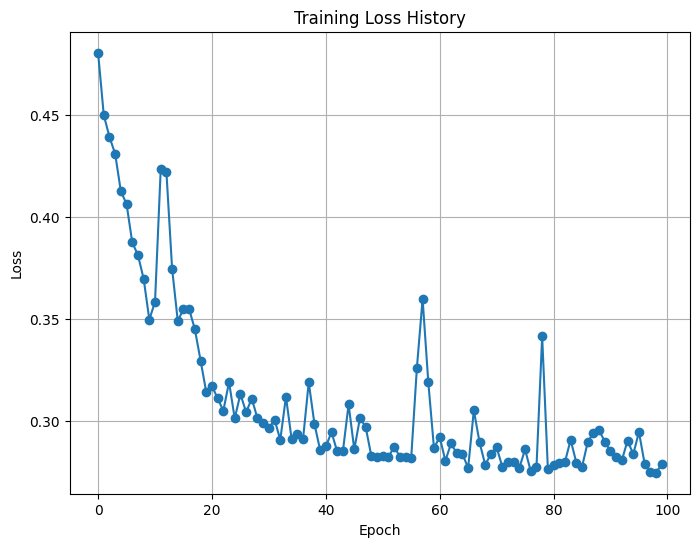

Test Accuracy: 0.9342
Test Recall:   0.6524
Test F1 Score: 0.5522

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12455
           1       0.09      0.36      0.14       185

    accuracy                           0.93     12640
   macro avg       0.54      0.65      0.55     12640
weighted avg       0.98      0.93      0.95     12640



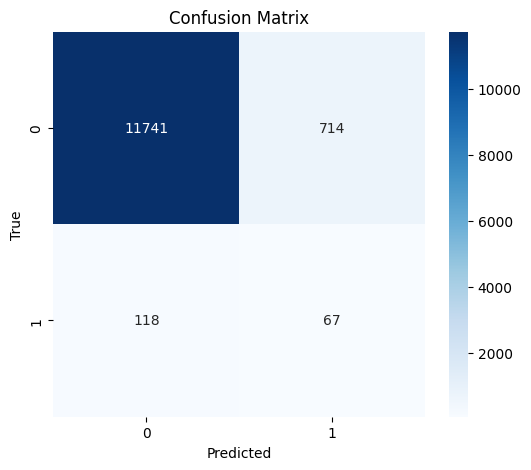

In [29]:
# Plot the training loss history
plt.figure(figsize=(8, 6))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.show()

# Evaluate the model on the test dataset
model.eval()
all_preds = []
all_labels = []
device = next(model.parameters()).device  # get current device from model

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute performance metrics
acc = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Recall:   {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [31]:
model

TransformerClassifier(
  (block1): AttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (dropout_attn): Dropout(p=0.1, inplace=False)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (linear): Linear(in_features=64, out_features=32, bias=True)
    (activation): ReLU()
    (dropout_linear): Dropout(p=0.1, inplace=False)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  )
  (block2): AttentionBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (dropout_attn): Dropout(p=0.1, inplace=False)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (linear): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
    (dropout_linear): Dropout(p=0.1, inplace=False)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
 

In [32]:
# Save the model's state dict
torch.save(model.state_dict(), "./transformer_classifier_100Epochs.pth")


In [ ]:
torch.cuda.is_available()